In [1]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib;
import matplotlib.pyplot as plt
import scipy.optimize as opt

/Users/rein/git/rebound/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


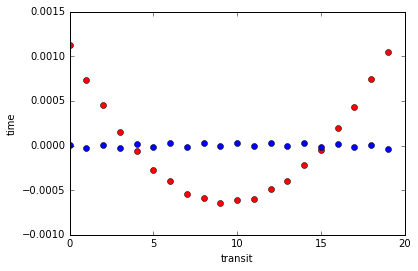

In [54]:
N_transit = 20

def transittimes(x,Ginteract=1.):
    a, m = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0], m=1e-5, a=a,e=0.1,omega=0.25)
    sim.add(primary=sim.particles[0], m=m, a=a*(2.**(2./3.)))# 1.757)
    sim.Ginteract = Ginteract
    var_dm = sim.add_variation()
    var_dm.init_particle(2,"m")
    var_da = sim.add_variation()
    var_da.init_particle(1,"a")
    var_dda = sim.add_variation(order=2, first_order=var_da)
    var_dda.init_particle(1,"a")
    var_da_dm = sim.add_variation(order=2, first_order=var_da, first_order_2=var_dm)
    var_da_dm.init_particle(1,"a","m")

    
    sim.move_to_com()
    tt = np.zeros(N_transit)
    tt_dda = np.zeros(N_transit)
    tt_da_dm = np.zeros(N_transit)
    tt_da = np.zeros(N_transit)
    tt_dm = np.zeros(N_transit)
    ps = sim.particles
    s = ps[0]
    p = ps[1]
    p_da    = var_da.particles[1]
    p_dm    = var_dm.particles[1]
    p_da_dm = var_da_dm.particles[1]
    p_dda   = var_dda.particles[1]
    i = 0
    while i<N_transit:
        y_old = (p.y-s.y)
        t_old = sim.t
        sim.integrate(sim.t+0.5) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
        t_new = sim.t
        if y_old*(p.y-s.y)<0. and p.x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
            while t_new-t_old>1e-9:   # bisect until prec of 1e-9 reached
                if y_old*(p.y-s.y)<0.:
                    t_new = sim.t
                else:
                    t_old = sim.t
                sim.integrate( (t_new+t_old)/2.)
            tt[i] = sim.t
            tt_dda[i] = p_dda.y/p.vy                         - 2. * p_da.y*p_da.vy/(p.vy)**2                        - p.y/(p.vy)**2 * p_dda.vy                        + 2. * p.y/(p.vy)**3 * p_da.vy*p_da.vy
            tt_da[i] = -p_da.y/p.vy + p.y/(p.vy**2) * p_da.vy
            tt_dm[i] = -p_dm.y/p.vy + p.y/(p.vy**2) * p_dm.vy
            tt_da_dm[i] = p_da_dm.y/p.vy                         - p_da.y*p_dm.vy/(p.vy)**2                        - p_dm.y*p_da.vy/(p.vy)**2                        - p.y/(p.vy)**2 * p_da_dm.vy                         + 2. * p.y/(p.vy)**3 * p_da.vy*p_dm.vy                        
            i += 1
            sim.integrate(sim.t+0.05)       # integrate 0.05 to be past the transit 
    return tt, -tt_da, -tt_dda, -tt_dm, -tt_da_dm



def chi2(x):
    a,m= x
    if m<0. or m>1e-2 or a>2. or a<0.1:
        return 1000.
    tt = transittimes(x)
    N = len(tt)
    chi2 = 0.
    for i in range(N):
        chi2     += (tt[i]-tt_obs[i])**2
    return chi2

def chi2_a(a):
    return chi2((a,0.))

def chi2_der2(x):
    tt, tt_da, tt_dda, tt_dm, tt_da_dm = transittimes_der2(x)
    N = len(tt)
    chi2 = 0.
    chi2_dda = 0.
    chi2_da_dm = 0.
    for i in range(N):
        chi2     += (tt[i]-tt_obs[i])**2
        chi2_dda += 2.* tt_dda[i]*(tt[i]-tt_obs[i]) + 2.*tt_da[i]*tt_da[i]
        chi2_da_dm += 2.* tt_da_dm[i]*(tt[i]-tt_obs[i]) + 2.*tt_da[i]*tt_dm[i]
    return chi2, chi2_dda, chi2_da_dm

def notrend(tt):
    N = len(tt)
    A = np.vstack([np.ones(N), range(N)]).T
    c, m = np.linalg.lstsq(A, tt)[0]
    tt_removed = (tt-m*np.array(range(N))-c)
    return tt_removed

tt_obs = transittimes((1.,1e-4),1)[0]/(2.*np.pi)
tt_obsn = transittimes((1.,1e-4),0.)[0]/(2.*np.pi)


tt, tt_dm, tt_ddm = transittimes((1.,0))[0:3]



fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.set_xlabel("transit")
ax.set_ylabel("time")
im = ax.plot(notrend(tt_obs), "ro")
im = ax.plot(notrend(tt_obsn), "bo")
#im = ax.plot(notrend(tt+1e-3*tt_dm), "go")



In [5]:
def null(A, eps=1e-15):
    u, s, vh = np.linalg.svd(A)
    null_mask = (s <= eps)
    null_space = np.compress(null_mask, vh, axis=0)
    return np.transpose(null_space)

In [36]:
N=16
grid = np.zeros((N,N))
grid2 = np.zeros((N,N))
gridm = np.linspace(0,1.5e-3,N)
Da=0.001
grida = np.linspace(1.-Da,1.+Da,N)
for i, m in enumerate(gridm):
    for j, a in enumerate(grida):
        c2 = chi2((a,m))
        grid[j][i] = c2

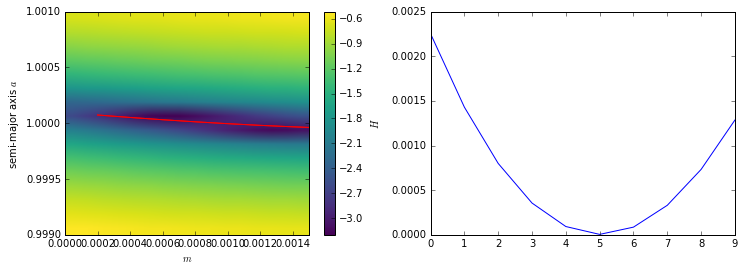

In [44]:
extent = [min(gridm),max(gridm),min(grida),max(grida)]
fig = plt.figure(figsize=(12,4))
ax = plt.subplot(121)
ax.set_xlim(extent[0],extent[1])
ax.set_ylabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_xlabel("$m$")
ax.plot(track[:,1],track[:,0],color="red")
im = ax.imshow(np.log10(grid), cmap="viridis", origin="lower",aspect='auto', extent=extent) #interpolation="none",
ax.plot(track[:,1],track[:,0],color="red")

cb = plt.colorbar(im, ax=ax)
cb.set_label('$ H$')

ax = plt.subplot(122)
ax.plot(trackc2)


In [8]:
def findBestFitNonInteracting():
    sol = opt.fmin_powell(chi2_a, 1.03, disp=False,ftol=1e-15,xtol=1e-15)
    return sol
a_start =  float(findBestFitNonInteracting())
print a_start

1.00009673046


rebound/particle.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return a.count(None) != len(a)


In [39]:
def H(x,lam):
    c2, c2_dda, c2_da_dm = chi2_der2((x,lam))
    return c2, np.array([[c2_dda, c2_da_dm],[0.,0.]])

In [43]:
iterations = 10
x, lam = a_start, 0.
ds = 1./iterations*2.0e-3
track = np.zeros((iterations,2))
trackc2 = np.zeros((iterations))
for i in range(iterations): # not quite correct, should be a loop until lam=1
    c2, _H = H(x,lam)
    nv = null(_H)[:,0]
    
    x += nv[0]*ds
    lam += nv[1]*ds
    
    track[i][0] = x
    track[i][1] = lam
    trackc2[i] = c2

In [33]:
print track

[[  1.00008390e+00   1.09248808e-04]
 [  1.00007153e+00   2.18551163e-04]
 [  1.00005963e+00   3.27906230e-04]
 [  1.00004823e+00   4.37313019e-04]
 [  1.00003731e+00   5.46770379e-04]
 [  1.00002691e+00   6.56277003e-04]
 [  1.00001702e+00   7.65831426e-04]
 [  1.00000765e+00   8.75432029e-04]
 [  9.99998820e-01   9.85077038e-04]
 [  9.99990534e-01   1.09476453e-03]]
